## Verifying the match between theory and simulation for the eigenvalue distribution in the case of $D_1 = Id$ and $D_2$ with mixed signature

In [1]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def generate_rand_mat(M,N,nb_AH_L1, nb_AH_L2):

    W1 = np.random.normal(0, 1, size = (N,M))/np.sqrt(M)
    W2 = np.random.normal(0, 1, size = (1,N))/np.sqrt(N)

    D1 = np.eye(M)
    D2 = np.eye(N)

    for i in range(nb_AH_L1):
        D1[i,i] = -1
    for i in range(nb_AH_L2):
        D2[i,i] = -1

    A = -(W2@W2.T)*D1
    B = -W1.T @ D2 @ W1
    
    return A+B

def get_eigenvals(mat):
    return np.linalg.eig(mat)[0]


def g0(z, c1, c2, a1, a2):
    return -1

def g1(z, c1, c2, a1, a2):
    return -z + (1-c1)*a1 - (1-c2) * a2

def g2(z, c1, c2, a1, a2):
    return (c2*a2 - c1*a1)*z + (c1*c2-c1-c2)*a1*a2

def g3(z, c1, c2, a1, a2):
    return c1*c2*a1*a2*z

def zeta(z, c1, c2, a1, a2):
    return g2(z, c1, c2, a1, a2)**2 - 3*g1(z, c1, c2, a1, a2)*g3(z, c1, c2, a1, a2)

def eta(z, c1, c2, a1, a2):
    return 2*g2(z, c1, c2, a1, a2)**3 - 9*g1(z, c1, c2, a1, a2)*g2(z, c1, c2, a1, a2)*g3(z, c1, c2, a1, a2) + 27*g0(z, c1, c2, a1, a2)*g3(z, c1, c2, a1, a2)**2

def G(z, c1, c2, a1, a2):
    return ((eta(z, c1, c2, a1, a2)+np.sqrt(0*1j+eta(z, c1, c2, a1, a2)**2-4*zeta(z, c1, c2, a1, a2)**3))/2+0*1j)**(1/3)

def p_hat(z, c1, c2, a1, a2):
    return np.sign(z)/(2*np.sqrt(3)*np.pi*g3(z, c1, c2, a1, a2)) * (G(z, c1, c2, a1, a2)- zeta(z, c1, c2, a1, a2)/G(z, c1, c2, a1, a2))


def solve_eta2_minus_4zeta3(c1, c2, a1, a2, *, return_poly=False, rtol=1e-10):
    """
    Solve  η(z)^2 - 4·ζ(z)^3 = 0 for z.

    Parameters
    ----------
    c1, c2, a1, a2 : float
        Model parameters.
    return_poly : bool, default False
        If True, also return the numpy.poly1d object for the degree-6 polynomial.
    rtol : float, default 1e-10
        Tolerance for discarding tiny imaginary parts when a root is (numerically) real.

    Returns
    -------
    roots : ndarray
        Array of complex roots.  Roots whose imaginary part is |Im| < rtol are
        returned as real numbers.
    poly  : numpy.poly1d, optional
        Returned only if `return_poly` is True.
    """
    # Declare the indeterminate z
    z = np.poly1d([1.0, 0.0])          # represents the polynomial “z”

    # --- building blocks ----------------------------------------------------
    g0 = -1

    g1 = -z + (1 - c1) * a1 - (1 - c2) * a2

    g2 = (c2 * a2 - c1 * a1) * z + (c1 * c2 - c1 - c2) * a1 * a2

    g3 = c1 * c2 * a1 * a2 * z

    zeta = g2**2 - 3 * g1 * g3                      # quadratic in z
    eta  = 2 * g2**3 - 9 * g1 * g2 * g3 + 27 * g0 * g3**2   # cubic in z

    # Target polynomial of (max) degree 6
    poly = eta**2 - 4 * zeta**3

    # Extract coefficients (highest power first) and drop leading zeros, if any
    coeffs = np.trim_zeros(poly.c, trim='f')

    # Solve
    roots = np.roots(coeffs)

    # Cast very-nearly-real roots to float
    roots = np.array([root.real if abs(root.imag) < rtol else root for root in roots])

    return (roots, poly) if return_poly else roots



In [2]:
init_scale = 1

M = 4000
N = 400
nb_AH_L1 = 0
nb_AH_L2 = 200

a1 = init_scale**2 * (N-nb_AH_L2)/M
a2 = init_scale**2 * nb_AH_L2/M
c1 = M/(N-nb_AH_L2)
c2 = M/nb_AH_L2

In [3]:
roots = solve_eta2_minus_4zeta3(c1, c2, a1, a2)

In [4]:
W1 = np.random.normal(0, 1, size = (N,M))/np.sqrt(M)*init_scale
W2 = np.random.normal(0, 1, size = (1,N))/np.sqrt(N)*init_scale

D1 = np.eye(M)
D2 = np.eye(N)

for i in range(nb_AH_L1):
    D1[i,i] = -1
for i in range(nb_AH_L2):
    D2[i,i] = -1

eigvals = np.linalg.eig(-W2@W2.T*D1-W1.T@D2@W1)[0]
w = (W2@W2.T)[0,0]
w

0.9609531021055455

/Users/ninou/anaconda3/lib/python3.9/site-packages/plotly/io/_kaleido.py:747: UserWarning:

full_figure_for_development is not recommended or necessary for production use in most circumstances. 
To suppress this warning, set warn=False



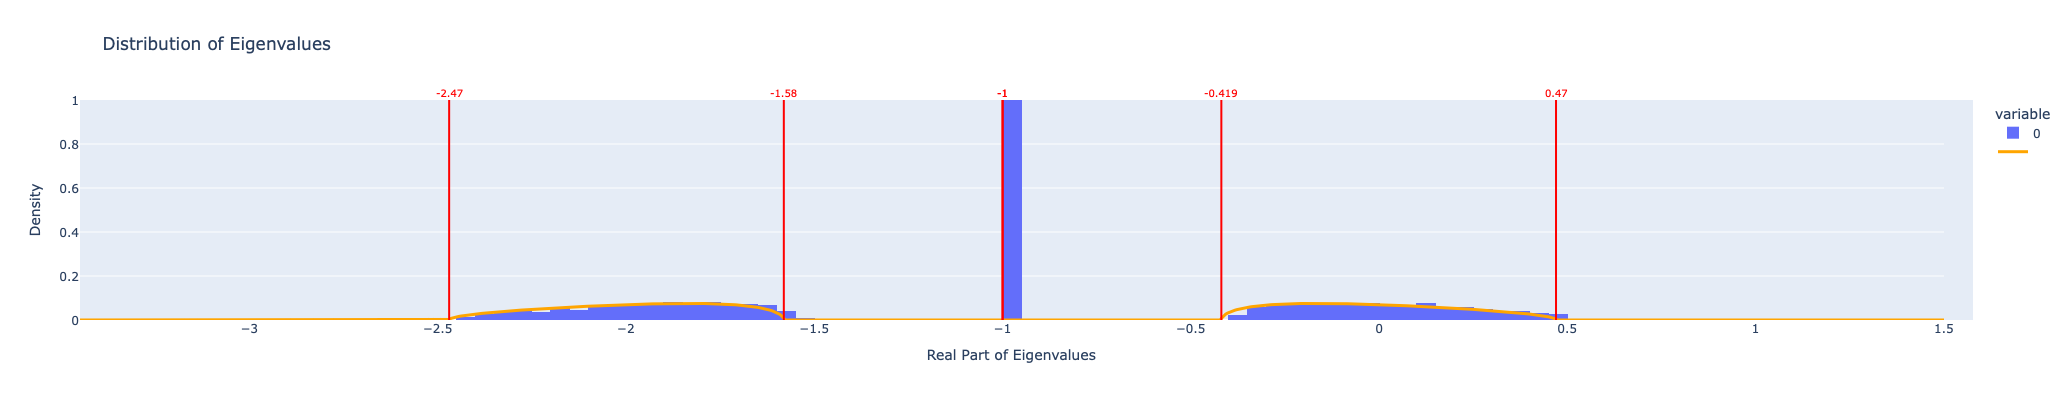

In [5]:
# Identify the peak in the real part of the eigenvalues
real_parts = eigvals.real

fig = px.histogram(eigvals.real, nbins = 100, title='Distribution of Eigenvalues',
                   #range_x=(-5,5),
                   range_y=(0,1), histnorm='probability density', width = 800, height = 400)
fig.update_layout(xaxis_title='Real Part of Eigenvalues', yaxis_title='Density' )



rtol   = 1e-10                                    # tolerance for “real‐enough”

# Ask Plotly to fill in all JS-computed defaults
full_fig = fig.full_figure_for_development()

# Now the trace **does** contain the auto-chosen bin info
xbins   = full_fig.data[0].xbins        # XBins object
start   = float(xbins.start)
end     = float(xbins.end)
size    = float(xbins.size)


# keep only (numerically) real roots
real_roots = [float(r.real) for r in roots if abs(np.imag(r)) < rtol]

# --- overlay vertical red lines --------------------------------------------
for x0 in real_roots:
    fig.add_vline(
        x=-init_scale**2-x0,
        line_color="red",
        line_width=2,
        line_dash="solid",
        annotation_text=f"{-init_scale**2-x0:.3g}",            # optional label
        annotation_position="top",
        annotation_font_color="red",
        annotation_font_size=10
    )
    
# ------------------------------------------------------------------
# 1)  Evaluate p̂(z) on a fine grid that covers the histogram range
# ------------------------------------------------------------------
x_grid = np.linspace(start-1, end+1, 1_000)                 # same range_x as the histogram
pdf_vals = p_hat(-init_scale**2-x_grid, c1, c2, a1, a2)           # vectorised call

# Keep points where p̂ is (numerically) real & finite
x_grid = x_grid
pdf_vals = - pdf_vals.real

pdf_counts = 2*pdf_vals 

# ------------------------------------------------------------------
# 3)  Add the theoretical curve to the existing figure
# ------------------------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=x_grid,
        y=pdf_counts,
        mode="lines",
        name="Theoretical $p\\_\\hat{}(z)$",
        line=dict(color="orange", width=3)
    )
)

fig.show()

#fig.write_image('eigv_distrib_L2_c=10_AHfrac=0.5.pdf')

## $D_1$ with mixed signature and $D_2 = Id$

In [6]:
M = 1000
N = 10000
nb_AH_L1 = 700
nb_AH_L2 = 0


c = M/N
p1 = (M-nb_AH_L1)/M
p2 = (nb_AH_L1)/M
Delta = 2*p1-1

In [7]:
W1 = np.random.normal(0, 1, size = (N,M))/np.sqrt(M)
W2 = np.random.normal(0,1, size =(1,N))/np.sqrt(N)

D1 = np.eye(M)
D2 = np.eye(N)

for i in range(nb_AH_L1):
    D1[i,i] = -1
for i in range(nb_AH_L2):
    D2[i,i] = -1

eigvals = np.linalg.eig(-(W2@W2.T)*D1 - W1.T@D2@W1)[0]


In [8]:
import math, numpy as np, sympy as sp

# ---------------------------------------------------------------------
# 1.  Helper: “clean” derivative–numerator polynomial  ( no √ left )
# ---------------------------------------------------------------------
def _dnum_poly(c, Delta, branch):
    """
    Return a SymPy Poly in ω whose roots are the stationary points of
    the map ω ↦ x(ω) corresponding to the chosen ± branch.

    The square root is eliminated algebraically, so the polynomial
    has *numeric* coefficients – no radicals left – and can be passed
    safely to `numpy.roots`.
    """
    ω = sp.symbols('omega')
    rad = 1 + 4*ω*(ω + Delta)
    s = sp.symbols('s')                       # placeholder for √rad

    # x(ω) for the indicated sign of the square‑root
    xω = 1/(c*(1-ω)) + (1 + branch*sp.sqrt(rad))/(2*ω)

    # ∂x/∂ω  ⇒  numerator / denominator
    num, den = sp.together(sp.diff(xω, ω)).as_numer_denom()

    # Replace √rad → s, build conjugate, multiply and clean
    num_s   = num.subs(sp.sqrt(rad),  s)
    num_con = num_s.subs(s, -s)
    expr    = sp.expand(num_s * num_con)          # now even in s
    expr    = expr.subs({s**2: rad})              # eliminate s²
    expr    = expr.subs(s, 0)                     # kill leftover s

    return sp.Poly(sp.expand(expr), ω)            # *pure* polynomial

# ---------------------------------------------------------------------
# 2.  Limiting density ρ(x)  ( needs only the quartic we derived )
# ---------------------------------------------------------------------
def _density(c, Delta, x):
    """Return limiting density ρ(x) via the imaginary part of ω(x+i0⁺)."""
    a4 = 4*(x**2 - 1)
    a3 = (-4*Delta*c - 8*c*x**2 - 4*c*x + 8*c + 8*x)/c
    a2 = (8*Delta*c**2 + 4*c**2*x**2 + 8*c**2*x - 4*c**2
          - 8*c*x - 4*c + 4)/c**2
    a1 = (-4*Delta*c - 4*c*x + 4)/c
    coeffs = [a4, a3, a2, a1, 0.0]
    roots  = np.roots(coeffs)
    # pick physical root (Im ω > 0 in upper half‑plane)
    phys   = [z for z in roots if z.imag > 1e-9]
    ω      = phys[0] if phys else sorted(roots, key=lambda z: abs(z.imag))[0]
    return ω.imag / math.pi

# ---------------------------------------------------------------------
# 3.  Public routine: spectral edges
# ---------------------------------------------------------------------
def spectral_edges(c, p_plus, tol=1e-8, ε=1e-3):
    """
    Return the ordered list of endpoints of the limiting spectrum of
    X = D + W Wᵀ for given aspect ratio c=M/N and spin fraction p_plus.
    If the list has length 2 → one band; length 4 → two bands.
    """
    Δ = 2*p_plus - 1
    xs = set()

    for branch in (+1, -1):
        poly = _dnum_poly(c, Δ, branch)
        coeffs = [complex(co.evalf()) for co in poly.all_coeffs()]
        # strip leading ~0’s so numpy.roots behaves
        while coeffs and abs(coeffs[0]) < tol:
            coeffs.pop(0)
        if len(coeffs) <= 1:          # constant → no roots
            continue
        for ω in np.roots(coeffs):
            if abs(ω.imag) < 1e-9:    # we only keep *real* ω
                ω = ω.real
                if abs(ω) < tol or abs(1-ω) < tol:
                    continue          # singular map ω↦x
                rad = 1 + 4*ω*(ω + Δ)
                if rad < 0:
                    continue          # branch‑cut: x(ω) complex
                x = 1/(c*(1-ω)) + (1 + branch*math.sqrt(rad))/(2*ω)
                if math.isfinite(x):
                    xs.add(x)

    # Filter candidate x’s: density jumps from 0 to >0
    edges = []
    for x in sorted(xs):
        ρL = _density(c, Δ, x - ε)
        ρR = _density(c, Δ, x + ε)
        if (ρL < tol < ρR) or (ρR < tol < ρL):
            edges.append(float(x))
    return edges

# ---------------------------------------------------------------------
# 4.  Quick sanity check including the troublesome  c = 0.1  case
# ---------------------------------------------------------------------
def demo():
    cases = [
        ("all  +", 1.0),
        ("balanced", 0.5),
        ("two‑band regime", 0.9),
        ("mostly –", 0.2),
    ]
    c = 1.2
    print(f"Aspect ratio  c = {c}\n" + "-"*50)
    for label, p in cases:
        ed = spectral_edges(c, p)
        bands = len(ed)//2
        print(f"{label:<12} p₊={p:<4} → {ed}   ({bands} band{'s' if bands>1 else ''})")

demo()


Aspect ratio  c = 1.2
--------------------------------------------------
all  +       p₊=1.0  → [1.0075914749827797, 4.659075191683888]   (1 band)
balanced     p₊=0.5  → [-0.9657468610716433, 0.8263004739532227, 1.058681362084724, 4.080765025033697]   (2 bands)
two‑band regime p₊=0.9  → [-0.7495959951702409, -0.005437618550268808, 1.0013487814457436, 4.558562881055254]   (2 bands)
mostly –     p₊=0.2  → [-0.9996905436461654, 3.5577293202856834]   (1 band)


In [9]:
supp_edges = -np.array(spectral_edges(c,p1))
supp_edges

array([ -4.01912579, -17.15526338])

/Users/ninou/anaconda3/lib/python3.9/site-packages/plotly/io/_kaleido.py:747: UserWarning:

full_figure_for_development is not recommended or necessary for production use in most circumstances. 
To suppress this warning, set warn=False



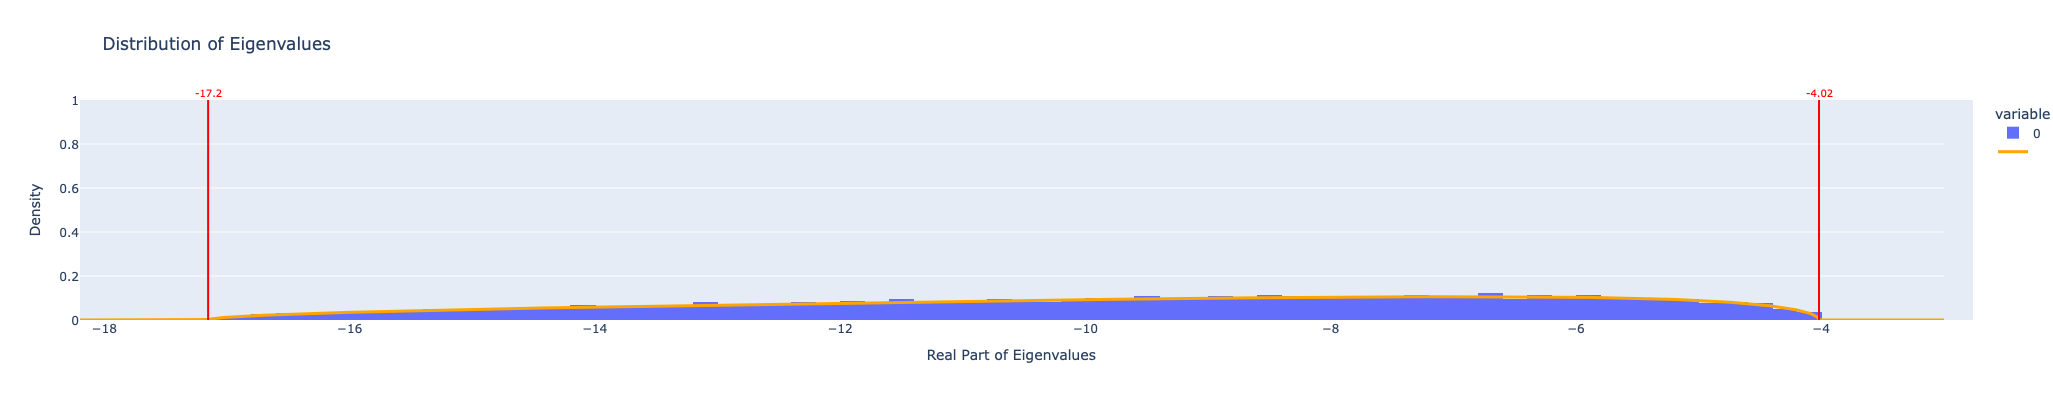

In [10]:
# Identify the peak in the real part of the eigenvalues
real_parts = eigvals.real

# Plot the histogram using Plotly
fig = px.histogram(eigvals.real, nbins = 100, title='Distribution of Eigenvalues',
                   #range_x=(-5,5),
                   range_y=(0,1), histnorm='probability density', width = 800, height = 400)
fig.update_layout(xaxis_title='Real Part of Eigenvalues', yaxis_title='Density' )



# Ask Plotly to fill in all JS-computed defaults
full_fig = fig.full_figure_for_development()

# Now the trace **does** contain the auto-chosen bin info
xbins   = full_fig.data[0].xbins        # XBins object
start   = float(xbins.start)
end     = float(xbins.end)
size    = float(xbins.size)



# --- overlay vertical red lines --------------------------------------------
for x0 in supp_edges:
    fig.add_vline(
        x=x0,
        line_color="red",
        line_width=2,
        line_dash="solid",
        annotation_text=f"{x0:.3g}",            # optional label
        annotation_position="top",
        annotation_font_color="red",
        annotation_font_size=10
    )
    


# ------------------------------------------------------------------
# 1)  Evaluate p̂(z) on a fine grid that covers the histogram range
# ------------------------------------------------------------------
x_grid = np.linspace(start-1, end+1, 1_000)
pdf_vals = []
for x in x_grid:
    pdf_vals.append(_density(c, Delta, -x))
pdf_vals = np.array(pdf_vals)

# ------------------------------------------------------------------
# 3)  Add the theoretical curve to the existing figure
# ------------------------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=x_grid,
        y=pdf_vals,
        mode="lines",
        name="Theoretical $p\\_\\hat{}(z)$",
        line=dict(color="orange", width=3)
    )
)




fig.show()
#fig.write_image('eigv_distrib_L1_c=0.1_AHfrac=0.7.pdf')